In [1]:
# The code was removed by Watson Studio for sharing.

# Data Science Capstone Project:    The Best Neighborhood in 
# Montreal for Opening a new Café/ Coffee Shop

## 1. Introduction
### *1.1. Business Problem*

In a metropolitan-multicultural city like Montreal, there are a number of places full of students and businesses which are suitable to open a new Coffee Shop close there. This study is going to help people planning to open a new Coffee Shop in Montreal. This idea have a heated debate over the optimal neighborhood for setting up shop, but the people would like to be located in an appropriate location of the city and in a spot where people already tend to drink Coffee. Assuming, demography of population and income are not an issue of each neighborhood in accordance with competitors already exist on the same regions. 

### *1.2. Target Audience*
The target audience of this report would be anyone who wants to buy or establish a Coffee Shop in Montreal, or anyone in Montreal just looking for a nice area to drink a coffee.

## 2. Data
In order to provide the stakeholders the necessary information to best make this decision, some data would be needed. For the city of Montreal has some public datasets that describe various aspects of the city, and Foursquare API allows access to collect competitors data on the same neighborhoods:

Altogether, there are three sets of data for our analysis:

**Administrative boundary of the Montréal agglomeration (Boroughs and related cities) Data**
- This is going to help us by providing Polygons delimiting the boroughs of the City of Montreal, boroughs and related cities constituting the agglomeration of Montreal and allowing us to select one of the suitable areas for new Coffee Shop

  http://donnees.ville.montreal.qc.ca/dataset/polygones-arrondissements


**Montreal's Census Profile** 
- This is going to provide data contains Montreal's 2016 census Aboriginal peoples; Education; Ethnic origin; Families, households and marital status; Housing; Immigration and citizenship; Income; Journey to work; Labour; Language; Language of work; Mobility; Population; Visible minority

https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page_Download-Telecharger.cfm?Lang=E&Tab=1&Geo1=POPC&Code1=0547&Geo2=PR&Code2=24&SearchText=Montreal&SearchType=Begins&SearchPR=01&B1=All&TABID=1&type=0

Montreal income census 2016 per borough can be downloaded as excell in the following url: 'http://ville.montreal.qc.ca/pls/portal/url/ITEM/55637C4923B8B03EE0530A930132B03E'




**Foursquare API**
- Foursquare data is robust and provides location data allows you to retrieve information about the most popular spots in each neighborhood in Montreal. 

## 3. Methodology

Let's start by importing all necessary libraries

In [2]:
!pip install beautifulsoup4
!pip install lxml
!pip install html5lib

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

from bs4 import BeautifulSoup
import lxml
import html5lib
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
import requests # library to handle requests
import random # library for random number generation
import xlrd
import urllib


# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

print('Libraries imported.')   

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

## Registered Business Data

Geographies:
      Montréal [Population centre], Quebec
      Quebec [Province]
      Topic(s): Aboriginal peoples; Education; 
      Ethnic origin; Families, households and marital status; 
      Housing; Immigration and citizenship; Income; Journey to work; 
      Labour; Language; Language of work; Mobility; Population; Visible minority
      
  https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/current-actuelle.cfm?Lang=E&Geo1=POPC&Code1=0547&Geo2=PR&Code2=24&B1=All&type=0&FILETYPE=CSV
  
  montreal income census 2016 = 'http://ville.montreal.qc.ca/pls/portal/url/ITEM/55637C4923B8B03EE0530A930132B03E'



  The file contains the boundaries of the boroughs of the City of Montreal and its cities linked in JSON format. 
 (Last update: 2013-03-21)
  http://donnees.ville.montreal.qc.ca/dataset/f38c91a1-e33f-4475-a112-3b84b1c60c1e/resource/a80e611f-5336-4306-ba2a-fd657f0f00fa/download/quartierreferencehabitation.geojson'

## Montreal , Boroughs and Neighborhoods data
#### Send the GET Request and examine the results for Montreal Neighborhoods and Boroughs

In [3]:
# url for Montreal borough and neighborhoods from Montreal Open Data Portal
url = 'http://donnees.ville.montreal.qc.ca/dataset/f38c91a1-e33f-4475-a112-3b84b1c60c1e/resource/1c142277-53f7-4801-9d19-c54acce747d8/download/quartierreferencehabitation.csv'
df = pd.read_csv(url)

df.drop(['nom_mun'],axis=1, inplace=True)
df.columns

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
df.columns = ['N_no','Neighborhood','B_no','Borough']

Let's Cleaning data for Montreal boroughs and neighborhoods

In [4]:
# keep only columns that include an assigned borough, and ignor cells with a borough that is Not assigned
montreal_data = df[df['Neighborhood']!= None]
montreal_data = montreal_data.reset_index(drop=True)

#If a cell has a neighborhood but a Not assigned borough, then the borough will be the same as the neighborhood
cond = montreal_data['Borough'].isnull() 
montreal_data.loc[cond, 'Borough'] = montreal_data.loc[cond, 'Neighborhood']

#montreal_data = montreal_data.groupby("Borough").agg(lambda x:','.join(set(x)))
montreal_data.drop(['N_no','B_no'],axis=1, inplace=True)
montreal_data.reset_index(drop=True, inplace=True)
montreal_data

Neighborhood                                   Borough
0            Rivière-des-Prairies  Rivière-des-Prairies–Pointe-aux-Trembles
1                      Beaurivage             Mercier–Hochelaga-Maisonneuve
2                  Tétreaultville             Mercier–Hochelaga-Maisonneuve
3                          Dupéré             Mercier–Hochelaga-Maisonneuve
4                        Guybourg             Mercier–Hochelaga-Maisonneuve
5                   Longue-Pointe             Mercier–Hochelaga-Maisonneuve
6                      Louis-Riel             Mercier–Hochelaga-Maisonneuve
7                  Marie-Victorin                 Rosemont–La Petite-Patrie
8                     Maisonneuve             Mercier–Hochelaga-Maisonneuve
9                     René-Goupil      Villeray–Saint-Michel–Parc-Extension
10                   Sainte-Lucie      Villeray–Saint-Michel–Parc-Extension
11              Sault-au-Récollet                     Ahuntsic-Cartierville
12                  Saint-Sulpice                     Ahuntsic-Cartierville
13                   Nicolas-Viel                     Ahuntsic-Cartierville
14              François-Perrault      Villeray–Saint-Michel–Parc-Extension
15                         Savane       Côte-des-Neiges–Notre-Dame-de-Grâce
16                        Snowdon       Côte-des-Neiges–Notre-Dame-de-Grâce
17             Côte-Saint-Antoine       Côte-des-Neiges–Notre-Dame-de-Grâce
18                    Ville-Émard                              Le Sud-Ouest
19                    Saint-Henri                              Le Sud-Ouest
20                Côte-Saint-Paul                              Le Sud-Ouest
21           Pointe-Saint-Charles                              Le Sud-Ouest
22               Petite-Bourgogne                              Le Sud-Ouest
23                       Montagne                               Ville-Marie
24                  René-Lévesque                               Ville-Marie
25              Édouard-Montpetit       Côte-des-Neiges–Notre-Dame-de-Grâce
26                      Parc-Kent       Côte-des-Neiges–Notre-Dame-de-Grâce
27                      Hochelaga             Mercier–Hochelaga-Maisonneuve
28                   Sainte-Marie                               Ville-Marie
29                    Préfontaine             Mercier–Hochelaga-Maisonneuve
..                            ...                                       ...
61                 Grande-Prairie                             Saint-Léonard
62                   Port-Maurice                             Saint-Léonard
63           Desmarchais-Crawford                                    Verdun
64                  Verdun-Centre                                    Verdun
65                 Ile-des-Soeurs                                    Verdun
66              Sault-Saint-Louis                                   LaSalle
67                Cecil-P.-Newman                                   LaSalle
68                  Lachine-Ouest                                   Lachine
69               Du College/Hodge                             Saint-Laurent
70                    Milton-Parc                     Le Plateau-Mont-Royal
71              Pierrefonds-Ouest                       Pierrefonds-Roxboro
72                   Montréal-Est                              Montréal-Est
73                      Westmount                                 Westmount
74                      Hampstead                                 Hampstead
75                 Côte-Saint-Luc                            Côte-Saint-Luc
76                 Montréal-Ouest                            Montréal-Ouest
77                         Dorval                                    Dorval
78                  Pointe-Claire                             Pointe-Claire
79                   Beaconsfield                              Beaconsfield
80                       Kirkland                                  Kirkland
81            Dollard-Des Ormeaux                       Dollard-Des O

## Census individual Income 
#### Send the GET Request and examine the results for individual income revenue per Montreal borough

In [5]:
# The code was removed by Watson Studio for sharing.

Let's Cleaning data for Montreal census income data

In [6]:
# drop unrelated data for analyzing income data
df.drop(['Unnamed: 3', 'Unnamed: 5', 'Unnamed: 7','Unnamed: 9','Unnamed: 11','Unnamed: 13',
            'Unnamed: 15','Unnamed: 17','Unnamed: 19','Unnamed: 21','Unnamed: 23','Unnamed: 25',
            'Unnamed: 27','Unnamed: 29','Unnamed: 31'], axis=1, inplace=True)

df.drop(df.index[[0,1,2,3,23,31,39,40,41,42]],inplace=True)

#determine columns related to boroughs name and coordinate income data
new_columns = ['Borough','Pre-tax income','Without total income',
               'Having a total income', 'Less than 10,000','10,000 to 19,999','20,000 to 29,999',
                '30,000 to 39,999','40,000 to 49,999','50,000 to 59,999','60,000 to 69,999',
               '70,000 to 79,999','80,000 to 89,999', '90,000 to 99,999', '100,000 and more',
                '100,000 to $ 149,999', '150,000 and more','Median income','Average income']
df.columns = new_columns

df.reset_index(drop=True, inplace=True)
df

Borough Pre-tax income  \
0                      Ahuntsic-Cartierville         106075   
1                                      Anjou          34455   
2        Côte-des-Neiges–Notre-Dame-de-Grâce         136325   
3                                    Lachine          35315   
4                                    LaSalle          62675   
5                      Le Plateau-Mont-Royal          89955   
6                               Le Sud-Ouest          65810   
7              L'Île-Bizard–Sainte-Geneviève          14855   
8              Mercier–Hochelaga-Maisonneuve         113215   
9                              Montréal-Nord          66005   
10                                 Outremont          17765   
11                       Pierrefonds-Roxboro          56355   
12  Rivière-des-Prairies–Pointe-aux-Trembles          87005   
13                 Rosemont–La Petite-Patrie         116880   
14                             Saint-Laurent          77635   
15                             Saint-Léonard          61570   
16                                    Verdun          57620   
17                               Ville-Marie          80050   
18      Villeray–Saint-Michel–Parc-Extension         118335   
19                               Baie-D'Urfé           3115   
20                              Beaconsfield          15595   
21                            Côte-Saint-Luc          25750   
22                       Dollard-Des Ormeaux          40295   
23                                    Dorval          16010   
24                                 Hampstead           5665   
25                                  Kirkland          16830   
26                              Montréal-Est           3125   
27                            Montréal-Ouest           4115   
28                                Mont-Royal          15810   
29                             Pointe-Claire          25320   
30                   Sainte-Anne-de-Bellevue           3895   
31                                Senneville            790   
32                                 Westmount          16755   

   Without total income Having a total income Less than 10,000  \
0                  4230                101845            15220   
1                  1410                 33045             3995   
2                  6725                129600            25395   
3                  1320                 33995             4820   
4                  2455                 60225             9340   
5                  2465                 87495            15580   
6                  2180                 63630             9215   
7                   665                 14185             2010   
8                  3160                110055            15015   
9                  3055                 62945            10275   
10                 1085                 16680             2495   
11                 3200                 53155             8160   
12                 3585                 83420             9910   
13                 3015                113865            13990   
14                 4170                 73465            13345   
15                 2555                 59010             8790   
16                 1720                 55890             7470   
17                 2680                 77365            17190   
18                 4795                113535            19050   
19                  185                  2935              480   
20                  955                 14640             2410   
21                 1000                 24750             3745   
22                 2135                 38165             5690   
23                  595                 15415             2090   
24                  240                  5430              900   
25                  895                 15935             2440   
26                  110                  3015              370   
27                  215                  3905 

Now let's calculate the individual number of average total income persons per borough.

We can see people with more than  30,000 $ annually  could be categorized as average income

In [7]:
# Convert income to integer type
df['Having a total income'] = df['Having a total income'].astype(np.int64)
df['Less than 10,000'] = df['Less than 10,000'].astype(np.int64)
df['10,000 to 19,999'] = df['10,000 to 19,999'].astype(np.int64)
df['20,000 to 29,999'] = df['20,000 to 29,999'].astype(np.int64)

# Calculate number of average individual income which is number of individual annual income more than 30,000$ 
# equal to number of total income minus number of individual income less than 10,000 to 29,999$
df['Total Average income'] = df['Having a total income']-df['Less than 10,000']- \
                             df['10,000 to 19,999']-df['20,000 to 29,999']                     

df_census_montreal = df[['Borough','Total Average income']]

df_census_montreal.sort_values(by='Borough',inplace=True)

df_census_montreal.reset_index(drop = True, inplace=True)
df_census_montreal

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Borough  Total Average income
0                      Ahuntsic-Cartierville                 49820
1                                      Anjou                 17205
2                                Baie-D'Urfé                  1775
3                               Beaconsfield                  9170
4                             Côte-Saint-Luc                 12780
5        Côte-des-Neiges–Notre-Dame-de-Grâce                 54745
6                        Dollard-Des Ormeaux                 20025
7                                     Dorval                  8900
8                                  Hampstead                  3385
9                                   Kirkland                  9550
10             L'Île-Bizard–Sainte-Geneviève                  8135
11                                   LaSalle                 28585
12                                   Lachine                 17670
13                     Le Plateau-Mont-Royal                 44035
14                              Le Sud-Ouest                 31095
15             Mercier–Hochelaga-Maisonneuve                 54810
16                                Mont-Royal                  9475
17                              Montréal-Est                  1485
18                             Montréal-Nord                 23795
19                            Montréal-Ouest                  2440
20                                 Outremont                 10440
21                       Pierrefonds-Roxboro                 27500
22                             Pointe-Claire                 14445
23  Rivière-des-Prairies–Pointe-aux-Trembles                 44395
24                 Rosemont–La Petite-Patrie                 59805
25                             Saint-Laurent                 33735
26                             Saint-Léonard                 26245
27                   Sainte-Anne-de-Bellevue                  2010
28                                Senneville                   470
29                                    Verdun                 30690
30                               Ville-Marie                 35035
31      Villeray–Saint-Michel–Parc-Extension                 44080
32                                 Westmount                 10135

#### Merging Datasets¶

Now, we can merge Montreal data with census data

In [8]:
montreal_Data = pd.merge(montreal_data, df_census_montreal, on='Borough' )
montreal_Data

Neighborhood                                   Borough  \
0            Rivière-des-Prairies  Rivière-des-Prairies–Pointe-aux-Trembles   
1             Pointe-aux-Trembles  Rivière-des-Prairies–Pointe-aux-Trembles   
2              Marc-Aurèle-Fortin  Rivière-des-Prairies–Pointe-aux-Trembles   
3                      Beaurivage             Mercier–Hochelaga-Maisonneuve   
4                  Tétreaultville             Mercier–Hochelaga-Maisonneuve   
5                          Dupéré             Mercier–Hochelaga-Maisonneuve   
6                        Guybourg             Mercier–Hochelaga-Maisonneuve   
7                   Longue-Pointe             Mercier–Hochelaga-Maisonneuve   
8                      Louis-Riel             Mercier–Hochelaga-Maisonneuve   
9                     Maisonneuve             Mercier–Hochelaga-Maisonneuve   
10                      Hochelaga             Mercier–Hochelaga-Maisonneuve   
11                    Préfontaine             Mercier–Hochelaga-Maisonneuve   
12                 Marie-Victorin                 Rosemont–La Petite-Patrie   
13                    Petite-Côte                 Rosemont–La Petite-Patrie   
14                 Vieux-Rosemont                 Rosemont–La Petite-Patrie   
15            Étienne Desmarteaux                 Rosemont–La Petite-Patrie   
16                   Louis-Hébert                 Rosemont–La Petite-Patrie   
17                  Saint-Édouard                 Rosemont–La Petite-Patrie   
18                 Père-Marquette                 Rosemont–La Petite-Patrie   
19                    René-Goupil      Villeray–Saint-Michel–Parc-Extension   
20                   Sainte-Lucie      Villeray–Saint-Michel–Parc-Extension   
21              François-Perrault      Villeray–Saint-Michel–Parc-Extension   
22                 Gabriel-Sagard      Villeray–Saint-Michel–Parc-Extension   
23                 Parc-Extension      Villeray–Saint-Michel–Parc-Extension   
24                     Parc-Jarry      Villeray–Saint-Michel–Parc-Extension   
25                       Crémazie      Villeray–Saint-Michel–Parc-Extension   
26              Sault-au-Récollet                     Ahuntsic-Cartierville   
27                  Saint-Sulpice                     Ahuntsic-Cartierville   
28                   Nicolas-Viel                     Ahuntsic-Cartierville   
29                  La Visitation                     Ahuntsic-Cartierville   
..                            ...                                       ...   
61                            Est                             Montréal-Nord   
62                         Centre                             Montréal-Nord   
63                          Ouest                             Montréal-Nord   
64                    Centre-Nord                             Montréal-Nord   
65                 Grande-Prairie                             Saint-Léonard   
66                   Port-Maurice                             Saint-Léonard   
67           Desmarchais-Crawford                                    Verdun   
68                  Verdun-Centre                                    Verdun   
69                 Ile-des-Soeurs                                    Verdun   
70              Sault-Saint-Louis                                   LaSalle   
71                Cecil-P.-Newman                                   LaSalle   
72                  Lachine-Ouest                                   Lachine   
73   Vieux-Lachine - Saint-Pierre                                   Lachine   
74              Pierrefonds-Ouest                       Pierrefonds-Roxboro   
75                Pierrefonds-Est                       Pierrefonds-Roxboro   
76                   Montréal-Est                              Montréal-Est   
77                      Westmount                                 Westmount   
78                      Hampstead                                 Hampstead   
79                 Côte-Saint-Luc                            Côte-Saint

Now, let find boroughs with more than average number total income compared with other boroughs

In [9]:
income_average_number = (montreal_Data['Total Average income'].min() +
                              montreal_Data['Total Average income'].max()) / 2

montreal_average_income = montreal_Data[montreal_Data['Total Average income'] >= income_average_number]
montreal_average_income.reset_index(drop=True, inplace=True)
montreal_average_income

Neighborhood                                   Borough  \
0   Rivière-des-Prairies  Rivière-des-Prairies–Pointe-aux-Trembles   
1    Pointe-aux-Trembles  Rivière-des-Prairies–Pointe-aux-Trembles   
2     Marc-Aurèle-Fortin  Rivière-des-Prairies–Pointe-aux-Trembles   
3             Beaurivage             Mercier–Hochelaga-Maisonneuve   
4         Tétreaultville             Mercier–Hochelaga-Maisonneuve   
5                 Dupéré             Mercier–Hochelaga-Maisonneuve   
6               Guybourg             Mercier–Hochelaga-Maisonneuve   
7          Longue-Pointe             Mercier–Hochelaga-Maisonneuve   
8             Louis-Riel             Mercier–Hochelaga-Maisonneuve   
9            Maisonneuve             Mercier–Hochelaga-Maisonneuve   
10             Hochelaga             Mercier–Hochelaga-Maisonneuve   
11           Préfontaine             Mercier–Hochelaga-Maisonneuve   
12        Marie-Victorin                 Rosemont–La Petite-Patrie   
13           Petite-Côte                 Rosemont–La Petite-Patrie   
14        Vieux-Rosemont                 Rosemont–La Petite-Patrie   
15   Étienne Desmarteaux                 Rosemont–La Petite-Patrie   
16          Louis-Hébert                 Rosemont–La Petite-Patrie   
17         Saint-Édouard                 Rosemont–La Petite-Patrie   
18        Père-Marquette                 Rosemont–La Petite-Patrie   
19           René-Goupil      Villeray–Saint-Michel–Parc-Extension   
20          Sainte-Lucie      Villeray–Saint-Michel–Parc-Extension   
21     François-Perrault      Villeray–Saint-Michel–Parc-Extension   
22        Gabriel-Sagard      Villeray–Saint-Michel–Parc-Extension   
23        Parc-Extension      Villeray–Saint-Michel–Parc-Extension   
24            Parc-Jarry      Villeray–Saint-Michel–Parc-Extension   
25              Crémazie      Villeray–Saint-Michel–Parc-Extension   
26     Sault-au-Récollet                     Ahuntsic-Cartierville   
27         Saint-Sulpice                     Ahuntsic-Cartierville   
28          Nicolas-Viel                     Ahuntsic-Cartierville   
29         La Visitation                     Ahuntsic-Cartierville   
..                   ...                                       ...   
32                Savane       Côte-des-Neiges–Notre-Dame-de-Grâce   
33               Snowdon       Côte-des-Neiges–Notre-Dame-de-Grâce   
34    Côte-Saint-Antoine       Côte-des-Neiges–Notre-Dame-de-Grâce   
35     Édouard-Montpetit       Côte-des-Neiges–Notre-Dame-de-Grâce   
36             Parc-Kent       Côte-des-Neiges–Notre-Dame-de-Grâce   
37                Loyola       Côte-des-Neiges–Notre-Dame-de-Grâce   
38         Upper Lachine       Côte-des-Neiges–Notre-Dame-de-Grâce   
39           Ville-Émard                              Le Sud-Ouest   
40           Saint-Henri                              Le Sud-Ouest   
41       Côte-Saint-Paul                              Le Sud-Ouest   
42  Pointe-Saint-Charles                              Le Sud-Ouest   
43      Petite-Bourgogne                              Le Sud-Ouest   
44              Montagne                               Ville-Marie   
45         René-Lévesque                               Ville-Marie   
46          Sainte-Marie                               Ville-Marie   
47        Vieux-Montréal                               Ville-Marie   
48              Lorimier                     Le Plateau-Mont-Royal   
49           Saint-Louis                     Le Plateau-Mont-Royal   
50       Parc-Lafontaine                     Le Plateau-Mont-Royal   
51          Parc-Laurier                     Le Plateau-Mont-Royal   
52              Mile End                     Le Plateau-Mont-Royal   
53           Milton-Parc                     Le Plateau-Mont-Royal   
54  Chameran/Montpellier                             Saint-Laurent   
55                Grenet                             Saint-Laurent   
56              Dutrisac                             Saint-Laurent   
57           Bois-Fran

Now let's get the coordinates of each neighborhood

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


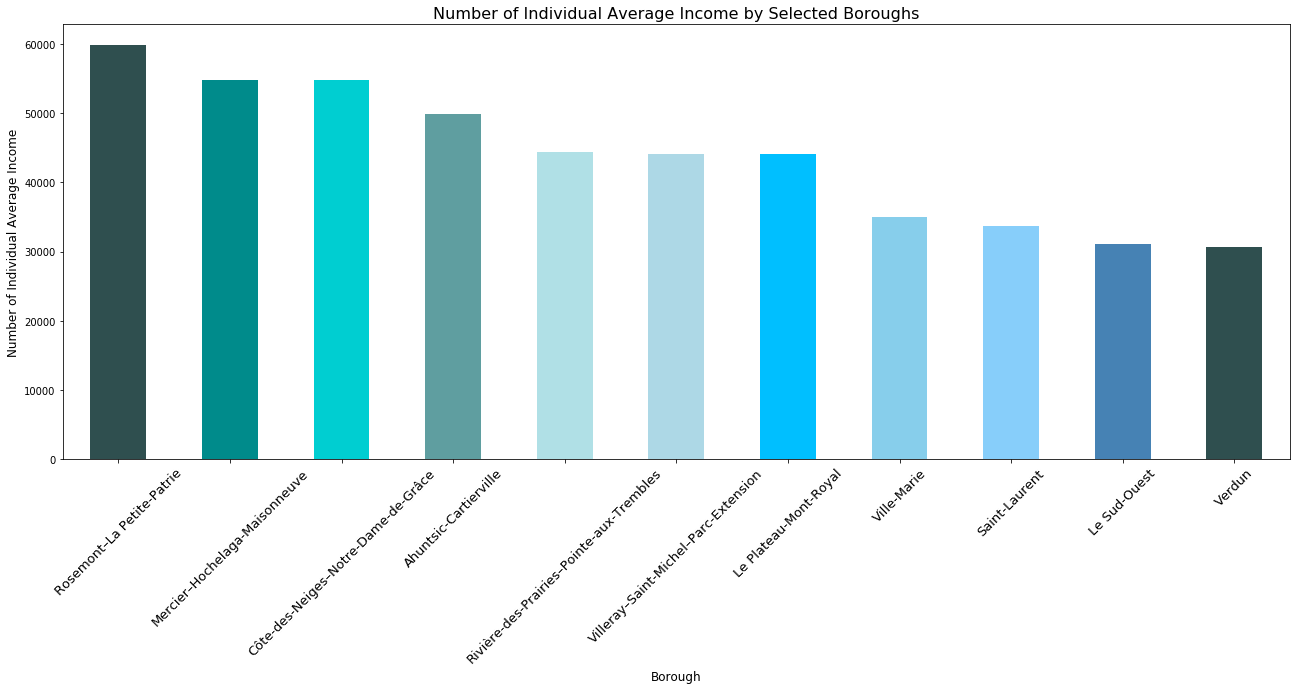

In [10]:
df_temp = (df_census_montreal['Total Average income'].min() +
                              df_census_montreal['Total Average income'].max()) / 2

montreal_income_show = df_census_montreal[df_census_montreal['Total Average income'] >= df_temp]
montreal_income_show.sort_values(by='Total Average income',inplace=True, ascending=False)
montreal_income_show.reset_index(drop=True, inplace=True)

montreal_income_show.plot.bar(x = 'Borough', y = 'Total Average income', 
                          title = "Number of Individual Average Income by Boroughs", 
                          legend = None, rot= 45, figsize = (22, 8), 
                          color=['darkslategray','darkcyan','darkturquoise',                               'cadetblue', 'powderblue','lightblue','deepskyblue',
                         'skyblue','lightskyblue','steelblue'])
plt.ylabel('Number of Individual Average Income', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Borough', fontsize=12)
plt.title('Number of Individual Average Income by Selected Boroughs', fontsize = 16)
plt.show()


From 33 boroughs in Montreal, there are 11 boroughs with more than average number of people with average income.

We focus on these borough with inside neighboods because there are more people with average income that interested to be potential customer for coffee shop.

Now let's get the coordinates of each of our selected neighborhoods

In [11]:
geolocat = Nominatim(user_agent="MTL_explorer" )

montreal_average_income['Coordinates'] = montreal_average_income['Neighborhood'].apply(geolocat.geocode).apply(lambda x: (x.latitude, x.longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


It looks like geopy had them all over the place. Almost coordinates for borough seem to be right, but let's plug in values from Google Maps for the rest and clean up the coordinates a little.

In [12]:
# Assign some coordinations directly 
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Maisonneuve' , 'Coordinates'] = "(45.5525, -73.5396)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Petite-Côte' , 'Coordinates'] = "(45.5335645324, -73.6077975688)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Sainte-Lucie' , 'Coordinates'] = "(45.5750, -73.6258)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Saint-Sulpice' , 'Coordinates'] = "(45.5590, -73.6414)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Savane' , 'Coordinates'] = "(45.5003, -73.6616)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Snowdon' , 'Coordinates'] = "(45.4836, -73.6291)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Loyola' , 'Coordinates'] = "(45.4582, -73.6405)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Saint-Henri' , 'Coordinates'] = "(45.4774, -73.5848)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Montagne' , 'Coordinates'] = "(45.5418, -73.8932)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Sainte-Marie' , 'Coordinates'] = "(45.5304, -73.5551)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Saint-Louis' , 'Coordinates'] = "(45.5169, -73.5700)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Mile End' , 'Coordinates'] = "(45.5240, -73.6005)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Grenet' , 'Coordinates'] = "(45.5000801, -73.6658478)"
montreal_average_income.loc[montreal_average_income.Neighborhood == 'Ile-des-Soeurs' , 'Coordinates'] = "(45.4615, -73.5464)"


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
pd.set_option('display.max_rows', 100)
montreal_GeoData = montreal_average_income
montreal_GeoData

Neighborhood                                   Borough  \
0   Rivière-des-Prairies  Rivière-des-Prairies–Pointe-aux-Trembles   
1    Pointe-aux-Trembles  Rivière-des-Prairies–Pointe-aux-Trembles   
2     Marc-Aurèle-Fortin  Rivière-des-Prairies–Pointe-aux-Trembles   
3             Beaurivage             Mercier–Hochelaga-Maisonneuve   
4         Tétreaultville             Mercier–Hochelaga-Maisonneuve   
5                 Dupéré             Mercier–Hochelaga-Maisonneuve   
6               Guybourg             Mercier–Hochelaga-Maisonneuve   
7          Longue-Pointe             Mercier–Hochelaga-Maisonneuve   
8             Louis-Riel             Mercier–Hochelaga-Maisonneuve   
9            Maisonneuve             Mercier–Hochelaga-Maisonneuve   
10             Hochelaga             Mercier–Hochelaga-Maisonneuve   
11           Préfontaine             Mercier–Hochelaga-Maisonneuve   
12        Marie-Victorin                 Rosemont–La Petite-Patrie   
13           Petite-Côte                 Rosemont–La Petite-Patrie   
14        Vieux-Rosemont                 Rosemont–La Petite-Patrie   
15   Étienne Desmarteaux                 Rosemont–La Petite-Patrie   
16          Louis-Hébert                 Rosemont–La Petite-Patrie   
17         Saint-Édouard                 Rosemont–La Petite-Patrie   
18        Père-Marquette                 Rosemont–La Petite-Patrie   
19           René-Goupil      Villeray–Saint-Michel–Parc-Extension   
20          Sainte-Lucie      Villeray–Saint-Michel–Parc-Extension   
21     François-Perrault      Villeray–Saint-Michel–Parc-Extension   
22        Gabriel-Sagard      Villeray–Saint-Michel–Parc-Extension   
23        Parc-Extension      Villeray–Saint-Michel–Parc-Extension   
24            Parc-Jarry      Villeray–Saint-Michel–Parc-Extension   
25              Crémazie      Villeray–Saint-Michel–Parc-Extension   
26     Sault-au-Récollet                     Ahuntsic-Cartierville   
27         Saint-Sulpice                     Ahuntsic-Cartierville   
28          Nicolas-Viel                     Ahuntsic-Cartierville   
29         La Visitation                     Ahuntsic-Cartierville   
30      Nouveau-Bordeaux                     Ahuntsic-Cartierville   
31          Cartierville                     Ahuntsic-Cartierville   
32                Savane       Côte-des-Neiges–Notre-Dame-de-Grâce   
33               Snowdon       Côte-des-Neiges–Notre-Dame-de-Grâce   
34    Côte-Saint-Antoine       Côte-des-Neiges–Notre-Dame-de-Grâce   
35     Édouard-Montpetit       Côte-des-Neiges–Notre-Dame-de-Grâce   
36             Parc-Kent       Côte-des-Neiges–Notre-Dame-de-Grâce   
37                Loyola       Côte-des-Neiges–Notre-Dame-de-Grâce   
38         Upper Lachine       Côte-des-Neiges–Notre-Dame-de-Grâce   
39           Ville-Émard                              Le Sud-Ouest   
40           Saint-Henri                              Le Sud-Ouest   
41       Côte-Saint-Paul                              Le Sud-Ouest   
42  Pointe-Saint-Charles                              Le Sud-Ouest   
43      Petite-Bourgogne                              Le Sud-Ouest   
44              Montagne                               Ville-Marie   
45         René-Lévesque                               Ville-Marie   
46          Sainte-Marie                               Ville-Marie   
47        Vieux-Montréal                               Ville-Marie   
48              Lorimier                     Le Plateau-Mont-Royal   
49           Saint-Louis                     Le Plateau-Mont-Royal   
50       Parc-Lafontaine                     Le Plateau-Mont-Royal   
51          Parc-Laurier                     Le Plateau-Mont-Royal   
52              Mile End                     Le Plateau-Mont-Royal   
53           Milton-Parc                     Le Plateau-Mont-Royal   
54  Chameran/Montpellier                             Saint-Laurent   
55                Grenet                             Saint-Laurent   
56              Dutris

Now, we can add the Latitude and Longitude in separate columns and merge our datasets

In [14]:
montreal_GeoData['Coordinates'] = montreal_GeoData['Coordinates'].astype(str)
montreal_GeoData[['Latitude','Longitude']] = montreal_GeoData['Coordinates'].str.strip('(').str.strip(')').str.split(', ', expand=True)

montreal_GeoData['Latitude'] = montreal_GeoData['Latitude'].astype(float)
montreal_GeoData['Longitude'] = montreal_GeoData['Longitude'].astype(float)
montreal_GeoData.style.format({
    'Latitude': '{:,.4f}'.format,
    'Longitude': '{:,.4f}'.format,
})

montreal_GeoData

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Neighborhood                                   Borough  \
0   Rivière-des-Prairies  Rivière-des-Prairies–Pointe-aux-Trembles   
1    Pointe-aux-Trembles  Rivière-des-Prairies–Pointe-aux-Trembles   
2     Marc-Aurèle-Fortin  Rivière-des-Prairies–Pointe-aux-Trembles   
3             Beaurivage             Mercier–Hochelaga-Maisonneuve   
4         Tétreaultville             Mercier–Hochelaga-Maisonneuve   
5                 Dupéré             Mercier–Hochelaga-Maisonneuve   
6               Guybourg             Mercier–Hochelaga-Maisonneuve   
7          Longue-Pointe             Mercier–Hochelaga-Maisonneuve   
8             Louis-Riel             Mercier–Hochelaga-Maisonneuve   
9            Maisonneuve             Mercier–Hochelaga-Maisonneuve   
10             Hochelaga             Mercier–Hochelaga-Maisonneuve   
11           Préfontaine             Mercier–Hochelaga-Maisonneuve   
12        Marie-Victorin                 Rosemont–La Petite-Patrie   
13           Petite-Côte                 Rosemont–La Petite-Patrie   
14        Vieux-Rosemont                 Rosemont–La Petite-Patrie   
15   Étienne Desmarteaux                 Rosemont–La Petite-Patrie   
16          Louis-Hébert                 Rosemont–La Petite-Patrie   
17         Saint-Édouard                 Rosemont–La Petite-Patrie   
18        Père-Marquette                 Rosemont–La Petite-Patrie   
19           René-Goupil      Villeray–Saint-Michel–Parc-Extension   
20          Sainte-Lucie      Villeray–Saint-Michel–Parc-Extension   
21     François-Perrault      Villeray–Saint-Michel–Parc-Extension   
22        Gabriel-Sagard      Villeray–Saint-Michel–Parc-Extension   
23        Parc-Extension      Villeray–Saint-Michel–Parc-Extension   
24            Parc-Jarry      Villeray–Saint-Michel–Parc-Extension   
25              Crémazie      Villeray–Saint-Michel–Parc-Extension   
26     Sault-au-Récollet                     Ahuntsic-Cartierville   
27         Saint-Sulpice                     Ahuntsic-Cartierville   
28          Nicolas-Viel                     Ahuntsic-Cartierville   
29         La Visitation                     Ahuntsic-Cartierville   
30      Nouveau-Bordeaux                     Ahuntsic-Cartierville   
31          Cartierville                     Ahuntsic-Cartierville   
32                Savane       Côte-des-Neiges–Notre-Dame-de-Grâce   
33               Snowdon       Côte-des-Neiges–Notre-Dame-de-Grâce   
34    Côte-Saint-Antoine       Côte-des-Neiges–Notre-Dame-de-Grâce   
35     Édouard-Montpetit       Côte-des-Neiges–Notre-Dame-de-Grâce   
36             Parc-Kent       Côte-des-Neiges–Notre-Dame-de-Grâce   
37                Loyola       Côte-des-Neiges–Notre-Dame-de-Grâce   
38         Upper Lachine       Côte-des-Neiges–Notre-Dame-de-Grâce   
39           Ville-Émard                              Le Sud-Ouest   
40           Saint-Henri                              Le Sud-Ouest   
41       Côte-Saint-Paul                              Le Sud-Ouest   
42  Pointe-Saint-Charles                              Le Sud-Ouest   
43      Petite-Bourgogne                              Le Sud-Ouest   
44              Montagne                               Ville-Marie   
45         René-Lévesque                               Ville-Marie   
46          Sainte-Marie                               Ville-Marie   
47        Vieux-Montréal                               Ville-Marie   
48              Lorimier                     Le Plateau-Mont-Royal   
49           Saint-Louis                     Le Plateau-Mont-Royal   
50       Parc-Lafontaine                     Le Plateau-Mont-Royal   
51          Parc-Laurier                     Le Plateau-Mont-Royal   
52              Mile End                     Le Plateau-Mont-Royal   
53           Milton-Parc                     Le Plateau-Mont-Royal   
54  Chameran/Montpellier                             Saint-Laurent   
55                Grenet                             Saint-Laurent   
56              Dutris

### MAP Montreal District

First, Montreal district and show income average number per borough

In [15]:
# url for Montreal Geo-Data from Montreal Open Data
url_Geo = 'http://donnees.ville.montreal.qc.ca/dataset/f38c91a1-e33f-4475-a112-3b84b1c60c1e/resource/a80e611f-5336-4306-ba2a-fd657f0f00fa/download/quartierreferencehabitation.geojson'

# Create map Montreal latitude and longitude values
montreal_map = folium.Map(location=[45.5017, -73.5673], zoom_start=11) 

# create a numpy array of length 6 and has linear spacing from the minium average income to the maximum average income
threshold_scale = np.linspace(montreal_GeoData['Total Average income'].min(),
                              montreal_GeoData['Total Average income'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration


# display the map
montreal_map.choropleth(
    geo_data=url_Geo,
    data=montreal_GeoData,
    columns=['Borough','Total Average income'],
    key_on='feature.properties.nom_arr', 
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average income in Montreal, by Borough',
    reset=True)


montreal_map

Now, we show the lable of boroughs with more than average number of people in contrast with total

In [16]:
# create map of Montreal using latitude and longitude values

# add markers to map
for lat, lng, label in zip(montreal_GeoData['Latitude'], montreal_GeoData['Longitude'], 
                           montreal_GeoData['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(montreal_map)  
    
montreal_map

### Foursquare Data Analysis¶

Let's write a function to search the most popular venues within a 500 meters radius of our neighborhoods.

In [17]:
CLIENT_ID = 'UMLQTFTZO43IIIZRCBEH2MQIYCCJJO3GVYHAWCGAOW4GHTGF' # your Foursquare ID
CLIENT_SECRET = 'Y1EDYK0ZPJDKS0EBTMQWBGGL5TM1PP2SOBZK3UCLQQX3JPNG' # your Foursquare Secret
VERSION = '20200517' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UMLQTFTZO43IIIZRCBEH2MQIYCCJJO3GVYHAWCGAOW4GHTGF
CLIENT_SECRET:Y1EDYK0ZPJDKS0EBTMQWBGGL5TM1PP2SOBZK3UCLQQX3JPNG


In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
montreal_venues = getNearbyVenues(names=montreal_average_income['Neighborhood'],
                                   latitudes=montreal_average_income['Latitude'],
                                   longitudes=montreal_average_income['Longitude']
                                  )

Rivière-des-Prairies
Pointe-aux-Trembles
Marc-Aurèle-Fortin
Beaurivage
Tétreaultville
Dupéré
Guybourg
Longue-Pointe
Louis-Riel
Maisonneuve
Hochelaga
Préfontaine
Marie-Victorin
Petite-Côte
Vieux-Rosemont
Étienne Desmarteaux
Louis-Hébert
Saint-Édouard
Père-Marquette
René-Goupil
Sainte-Lucie
François-Perrault
Gabriel-Sagard
Parc-Extension
Parc-Jarry
Crémazie
Sault-au-Récollet
Saint-Sulpice
Nicolas-Viel
La Visitation
Nouveau-Bordeaux
Cartierville
Savane
Snowdon
Côte-Saint-Antoine
Édouard-Montpetit
Parc-Kent
Loyola
Upper Lachine
Ville-Émard
Saint-Henri
Côte-Saint-Paul
Pointe-Saint-Charles
Petite-Bourgogne
Montagne
René-Lévesque
Sainte-Marie
Vieux-Montréal
Lorimier
Saint-Louis
Parc-Lafontaine
Parc-Laurier
Mile End
Milton-Parc
Chameran/Montpellier
Grenet
Dutrisac
Bois-Francs
Du College/Hodge
Desmarchais-Crawford
Verdun-Centre
Ile-des-Soeurs


In [20]:
#Le'ts see the shape of our dataframe
print(montreal_venues.shape)
montreal_venues

(1530, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Rivière-des-Prairies              45.667964              -73.536857   
1      Pointe-aux-Trembles              45.667824              -73.505133   
2      Pointe-aux-Trembles              45.667824              -73.505133   
3      Pointe-aux-Trembles              45.667824              -73.505133   
4      Pointe-aux-Trembles              45.667824              -73.505133   
5       Marc-Aurèle-Fortin              45.633370              -73.591508   
6       Marc-Aurèle-Fortin              45.633370              -73.591508   
7       Marc-Aurèle-Fortin              45.633370              -73.591508   
8       Marc-Aurèle-Fortin              45.633370              -73.591508   
9       Marc-Aurèle-Fortin              45.633370              -73.591508   
10      Marc-Aurèle-Fortin              45.633370              -73.591508   
11      Marc-Aurèle-Fortin              45.633370              -73.591508   
12              Beaurivage              45.598013              -73.513942   
13              Beaurivage              45.598013              -73.513942   
14              Beaurivage              45.598013              -73.513942   
15              Beaurivage              45.598013              -73.513942   
16              Beaurivage              45.598013              -73.513942   
17              Beaurivage              45.598013              -73.513942   
18              Beaurivage              45.598013              -73.513942   
19              Beaurivage              45.598013              -73.513942   
20              Beaurivage              45.598013              -73.513942   
21          Tétreaultville              45.601646              -73.524579   
22          Tétreaultville              45.601646              -73.524579   
23          Tétreaultville              45.601646              -73.524579   
24          Tétreaultville              45.601646              -73.524579   
25          Tétreaultville              45.601646              -73.524579   
26          Tétreaultville              45.601646              -73.524579   
27          Tétreaultville              45.601646              -73.524579   
28          Tétreaultville              45.601646              -73.524579   
29          Tétreaultville              45.601646              -73.524579   
30          Tétreaultville              45.601646              -73.524579   
31                  Dupéré              45.604441              -73.533697   
32                  Dupéré              45.604441              -73.533697   
33                  Dupéré              45.604441              -73.533697   
34                  Dupéré              45.604441              -73.533697   
35                  Dupéré              45.604441              -73.533697   
36                  Dupéré              45.604441              -73.533697   
37                Guybourg              45.573289              -73.521329   
38                Guybourg              45.573289              -73.521329   
39           Longue-Pointe              45.577884              -73.537499   
40           Longue-Pointe              45.577884              -73.537499   
41           Longue-Pointe              45.577884              -73.537499   
42           Longue-Pointe              45.577884              -73.537499   
43           Longue-Pointe              45.577884              -73.537499   
44           Longue-Pointe              45.577884              -73.537499   
45           Longue-Pointe              45.577884              -73.537499   
46           Longue-Pointe              45.577884              -73.537499   
47           Longue-Pointe              45.577884              -73.537499   
48           Longue-Pointe              45.577884              -73.537499   
49           Longue-Pointe              45.577884              -73.537499   
...                    ...                    ...                     ...   
1480      

In [21]:
montreal_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                 
Beaurivage                                9                       9      9   
Bois-Francs                               4                       4      4   
Cartierville                              3                       3      3   
Chameran/Montpellier                      7                       7      7   
Crémazie                                 25                      25     25   
Côte-Saint-Antoine                       43                      43     43   
Côte-Saint-Paul                           4                       4      4   
Desmarchais-Crawford                      4                       4      4   
Du College/Hodge                         35                      35     35   
Dupéré                                    6                       6      6   
Dutrisac                                  5                       5      5   
François-Perrault                         5                       5      5   
Gabriel-Sagard                           10                      10     10   
Grenet                                    8                       8      8   
Guybourg                                  2                       2      2   
Hochelaga                                27                      27     27   
Ile-des-Soeurs                            6                       6      6   
La Visitation                             6                       6      6   
Longue-Pointe                            11                      11     11   
Lorimier                                 69                      69     69   
Louis-Hébert                             45                      45     45   
Louis-Riel                                2                       2      2   
Loyola                                   11                      11     11   
Maisonneuve                              42                      42     42   
Marc-Aurèle-Fortin                        7                       7      7   
Marie-Victorin                            8                       8      8   
Mile End                                 65                      65     65   
Milton-Parc                              71                      71     71   
Montagne                                  7                       7      7   
Nicolas-Viel                             13                      13     13   
Nouveau-Bordeaux                         11                      11     11   
Parc-Extension                           24                      24     24   
Parc-Jarry                               21                      21     21   
Parc-Kent                                11                      11     11   
Parc-Lafontaine                          25                      25     25   
Parc-Laurier                             36                      36     36   
Petite-Bourgogne                         32                      32     32   
Petite-Côte                              83                      83     83   
Pointe-Saint-Charles                     16                      16     16   
Pointe-aux-Trembles                       4                       4      4   
Préfontaine                              19                      19     19   
Père-Marquette                           76                      76     76   
René-Goupil                               5                       5      5   
René-Lévesque                           100                     100    100   
Rivière-des-Prairies                      1                       1      1   
Saint-Henri                              57                      57     57   
Saint-Louis                             100                     100    100   
Saint-Sulpice                             4                       4      4   
Sainte-Lucie                              4                       4      4   
Sainte-Marie                             26 

Next find, How many venues are in neighborhoods?

In [22]:
print('There are {} uniques categories.'.format(len(montreal_venues['Venue Category'].unique())))

There are 249 uniques categories.


Now, let's list more frequent venue categories in these boroughs

In [23]:
montreal_top_venues = montreal_venues.groupby('Venue Category', as_index = False).count().sort_values('Neighborhood', ascending = False).head(10)
montreal_top_venues = montreal_top_venues[['Venue Category','Neighborhood']]
montreal_top_venues.rename(columns={'Neighborhood': 'Frequency'}, inplace = True)
montreal_top_venues

Venue Category  Frequency
39                Café         85
176           Pharmacy         50
195         Restaurant         48
170               Park         47
51         Coffee Shop         47
14              Bakery         44
178        Pizza Place         44
103      Grocery Store         40
92   French Restaurant         39
199     Sandwich Place         33

The most common venue categories in Montreal neighborhoods?

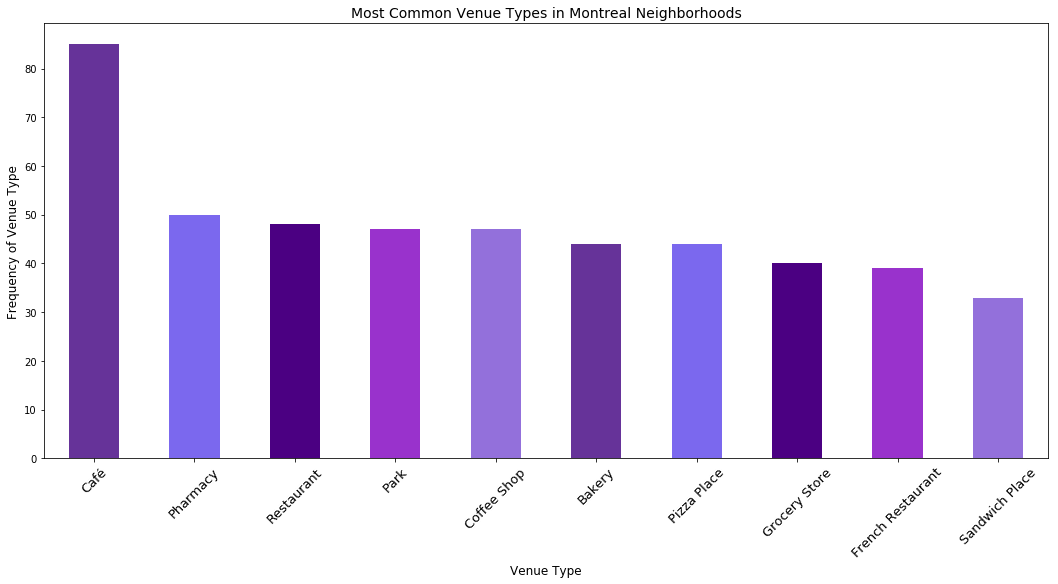

In [24]:

montreal_top_venues.plot.bar(x='Venue Category', y='Frequency', legend = None, title = "Most common venue types in MTL neighborhoods", 
                             rot= 45, figsize = (18, 8), color=['rebeccapurple','mediumslateblue','indigo','darkorchid','mediumpurple'])



plt.ylabel('Frequency of Venue Type', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Venue Type', fontsize=12)
plt.title('Most Common Venue Types in Montreal Neighborhoods', fontsize = 14)
plt.show()

It looks like Cafe and Coffee shops are the most common venue type, followed by Pharmacy, Park, Bakery, and some restaurants.

Let's do some one hot encoding to further analyze our results.



In [25]:
# one hot encoding
montreal_onehot = pd.get_dummies(montreal_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
montreal_onehot['Neighborhood'] = montreal_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [montreal_onehot.columns[-1]] + list(montreal_onehot.columns[:-1])
montreal_onehot = montreal_onehot[fixed_columns]

montreal_onehot.head()

Yoga Studio  Afghan Restaurant  American Restaurant  Arepa Restaurant  \
0            0                  0                    0                 0   
1            0                  0                    0                 0   
2            0                  0                    0                 0   
3            0                  0                    0                 0   
4            0                  0                    0                 0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   
3            0           0                    0                     0   
4            0           0                    0                     0   

   Asian Restaurant  Athletics & Sports  ...  Tibetan Restaurant  \
0                 0                   0  ...                   0   
1                 0                   0  ...                   0   
2                 0                   0  ...                   0   
3                 0                   0  ...                   0   
4                 0                   0  ...                   0   

   Toy / Game Store  Train Station  University  Vegetarian / Vegan Restaurant  \
0                 0              0           0                              0   
1                 0              0           0                              0   
2                 0              0           0                              0   
3                 0              0           0                              0   
4                 0              0           0                              0   

   Video Store  Vietnamese Restaurant  Wine Bar  Wine Shop  Women's Store  
0            0                      0         0          0              0  
1            0                      0         0          0              0  
2            0                      0         0          0              0  
3            0                      0         0          0              0  
4            0                      0         0          0              0  

[5 rows x 249 columns]

In [26]:
montreal_onehot.shape

(1530, 249)

In [27]:
montreal_grouped = montreal_onehot.groupby('Neighborhood').mean().reset_index()
montreal_grouped

Neighborhood  Yoga Studio  Afghan Restaurant  American Restaurant  \
0             Beaurivage     0.000000               0.00             0.000000   
1            Bois-Francs     0.000000               0.00             0.000000   
2           Cartierville     0.000000               0.00             0.000000   
3   Chameran/Montpellier     0.000000               0.00             0.000000   
4               Crémazie     0.000000               0.00             0.000000   
5     Côte-Saint-Antoine     0.023256               0.00             0.000000   
6        Côte-Saint-Paul     0.000000               0.00             0.000000   
7   Desmarchais-Crawford     0.000000               0.00             0.000000   
8       Du College/Hodge     0.000000               0.00             0.028571   
9                 Dupéré     0.000000               0.00             0.000000   
10              Dutrisac     0.000000               0.00             0.000000   
11     François-Perrault     0.000000               0.00             0.000000   
12        Gabriel-Sagard     0.000000               0.00             0.000000   
13                Grenet     0.000000               0.00             0.000000   
14              Guybourg     0.000000               0.00             0.000000   
15             Hochelaga     0.000000               0.00             0.000000   
16        Ile-des-Soeurs     0.000000               0.00             0.000000   
17         La Visitation     0.000000               0.00             0.000000   
18         Longue-Pointe     0.000000               0.00             0.000000   
19              Lorimier     0.000000               0.00             0.014493   
20          Louis-Hébert     0.000000               0.00             0.000000   
21            Louis-Riel     0.000000               0.00             0.000000   
22                Loyola     0.000000               0.00             0.000000   
23           Maisonneuve     0.000000               0.00             0.000000   
24    Marc-Aurèle-Fortin     0.000000               0.00             0.000000   
25        Marie-Victorin     0.000000               0.00             0.000000   
26              Mile End     0.015385               0.00             0.000000   
27           Milton-Parc     0.000000               0.00             0.000000   
28              Montagne     0.000000               0.00             0.000000   
29          Nicolas-Viel     0.000000               0.00             0.000000   
30      Nouveau-Bordeaux     0.000000               0.00             0.000000   
31        Parc-Extension     0.000000               0.00             0.000000   
32            Parc-Jarry     0.000000               0.00             0.000000   
33             Parc-Kent     0.000000               0.00             0.000000   
34       Parc-Lafontaine     0.000000               0.04             0.000000   
35          Parc-Laurier     0.027778               0.00             0.000000   
36      Petite-Bourgogne     0.000000               0.00             0.000000   
37           Petite-Côte     0.000000               0.00             0.000000   
38  Pointe-Saint-Charles     0.000000               0.00             0.000000   
39   Pointe-aux-Trembles     0.000000               0.00             0.000000   
40           Préfontaine     0.000000               0.00             0.000000   
41        Père-Marquette     0.000000               0.00             0.000000   
42           René-Goupil     0.000000               0.00             0.000000   
43         René-Lévesque     0.000000               0.00             0.000000   
44  Rivière-des-Prairies     0.000000               0.00             0.000000   
45           Saint-Henri     0.017544               0.00             0.000000   
46           Saint-Louis     0.020000               0.00             0.000000   
47         Saint-Sulpice     0.000000               0.00             0.000000   
48          Sainte-Lucie     0.000000      

We can now see the frequency of the top 5 types of venues for each neighborhood

In [28]:
num_top_venues = 5

for hood in montreal_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = montreal_grouped[montreal_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Beaurivage----
          venue  freq
0      Pharmacy  0.22
1         Diner  0.11
2   Pizza Place  0.11
3          Park  0.11
4  Liquor Store  0.11


----Bois-Francs----
          venue  freq
0      Ski Area  0.25
1   Coffee Shop  0.25
2  Home Service  0.25
3    Restaurant  0.25
4   Yoga Studio  0.00


----Cartierville----
                        venue  freq
0  Construction & Landscaping  0.33
1                        Park  0.33
2                 Tailor Shop  0.33
3                 Music Store  0.00
4                 Music Venue  0.00


----Chameran/Montpellier----
                       venue  freq
0               Liquor Store  0.14
1             Cosmetics Shop  0.14
2      Vietnamese Restaurant  0.14
3  Middle Eastern Restaurant  0.14
4              Train Station  0.14


----Crémazie----
                 venue  freq
0          Coffee Shop  0.16
1                 Café  0.12
2       Ice Cream Shop  0.04
3  Sporting Goods Shop  0.04
4                 Park  0.04


----Côte-Saint-Antoi

Now, we can place our data into a data frame of the most popular venues for each neighborhood

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = montreal_grouped['Neighborhood']

for ind in np.arange(montreal_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(montreal_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood       1st Most Common Venue 2nd Most Common Venue  \
0            Beaurivage                    Pharmacy  Fast Food Restaurant   
1           Bois-Francs                 Coffee Shop              Ski Area   
2          Cartierville  Construction & Landscaping                  Park   
3  Chameran/Montpellier   Middle Eastern Restaurant         Train Station   
4              Crémazie                 Coffee Shop                  Café   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Liquor Store           Pizza Place                 Diner   
1              Home Service            Restaurant         Women's Store   
2               Tailor Shop    Dongbei Restaurant     Fish & Chips Shop   
3              Liquor Store    Falafel Restaurant              Pharmacy   
4  Mediterranean Restaurant      Sushi Restaurant                  Park   

  6th Most Common Venue  7th Most Common Venue        8th Most Common Venue  \
0                  Park         Baseball Field                  Supermarket   
1            Donut Shop    Dumpling Restaurant  Eastern European Restaurant   
2   Filipino Restaurant   Fast Food Restaurant               Farmers Market   
3        Cosmetics Shop  Vietnamese Restaurant          Filipino Restaurant   
4                   Pub           Optical Shop                   Restaurant   

  9th Most Common Venue       10th Most Common Venue  
0         Women's Store  Eastern European Restaurant  
1     Electronics Store         Ethiopian Restaurant  
2    Falafel Restaurant                  Event Space  
3  Fast Food Restaurant               Farmers Market  
4              Bus Stop         Fast Food Restaurant

### Neighborhood Clustering¶

Let's use K means clustering to cluster our neighborhoods for more insights!

In [31]:
# set number of clusters
kclusters = 3

montreal_grouped_clustering = montreal_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(montreal_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 2, 1, 1, 1, 2, 2, 1, 1], dtype=int32)

Now create a data frame that includes the cluster as well as the top 10 venues for each neighborhood

In [32]:
#neighborhoods_venues_sorted
montreal_data_merged = montreal_average_income
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [33]:
neighborhoods_venues_sorted.head()

Cluster Labels          Neighborhood       1st Most Common Venue  \
0               1            Beaurivage                    Pharmacy   
1               1           Bois-Francs                 Coffee Shop   
2               2          Cartierville  Construction & Landscaping   
3               1  Chameran/Montpellier   Middle Eastern Restaurant   
4               1              Crémazie                 Coffee Shop   

  2nd Most Common Venue     3rd Most Common Venue 4th Most Common Venue  \
0  Fast Food Restaurant              Liquor Store           Pizza Place   
1              Ski Area              Home Service            Restaurant   
2                  Park               Tailor Shop    Dongbei Restaurant   
3         Train Station              Liquor Store    Falafel Restaurant   
4                  Café  Mediterranean Restaurant      Sushi Restaurant   

  5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
0                 Diner                  Park         Baseball Field   
1         Women's Store            Donut Shop    Dumpling Restaurant   
2     Fish & Chips Shop   Filipino Restaurant   Fast Food Restaurant   
3              Pharmacy        Cosmetics Shop  Vietnamese Restaurant   
4                  Park                   Pub           Optical Shop   

         8th Most Common Venue 9th Most Common Venue  \
0                  Supermarket         Women's Store   
1  Eastern European Restaurant     Electronics Store   
2               Farmers Market    Falafel Restaurant   
3          Filipino Restaurant  Fast Food Restaurant   
4                   Restaurant              Bus Stop   

        10th Most Common Venue  
0  Eastern European Restaurant  
1         Ethiopian Restaurant  
2                  Event Space  
3               Farmers Market  
4         Fast Food Restaurant

In [34]:
# merge Montreal_grouped with Montreal_data to add latitude/longitude for each neighborhood
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.rename(columns={'Neighborhood':'Borough'})

montreal_data_merged = montreal_data_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'),
                                                 on='Neighborhood')

In [35]:
montreal_data_merged.head() # check the last columns!

Neighborhood                                   Borough  \
0  Rivière-des-Prairies  Rivière-des-Prairies–Pointe-aux-Trembles   
1   Pointe-aux-Trembles  Rivière-des-Prairies–Pointe-aux-Trembles   
2    Marc-Aurèle-Fortin  Rivière-des-Prairies–Pointe-aux-Trembles   
3            Beaurivage             Mercier–Hochelaga-Maisonneuve   
4        Tétreaultville             Mercier–Hochelaga-Maisonneuve   

   Total Average income                               Coordinates   Latitude  \
0                 44395          (45.6679644, -73.53685698747795)  45.667964   
1                 44395  (45.667824350000004, -73.50513339569802)  45.667824   
2                 44395          (45.6333698, -73.59150796683336)  45.633370   
3                 54810  (45.598012749999995, -73.51394201653504)  45.598013   
4                 54810            (45.601646, -73.5245787765453)  45.601646   

   Longitude  Cluster Labels  1st Most Common Venue 2nd Most Common Venue  \
0 -73.536857             0.0               Bus Stop         Women's Store   
1 -73.505133             1.0      Convenience Store      Sushi Restaurant   
2 -73.591508             1.0               Pharmacy  Fast Food Restaurant   
3 -73.513942             1.0               Pharmacy  Fast Food Restaurant   
4 -73.524579             1.0  Portuguese Restaurant           Pizza Place   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Donut Shop           Flower Shop     Fish & Chips Shop   
1              Pharmacy           Supermarket         Women's Store   
2         Grocery Store    Italian Restaurant     Convenience Store   
3          Liquor Store           Pizza Place                 Diner   
4           Supermarket            Restaurant         Deli / Bodega   

  6th Most Common Venue 7th Most Common Venue        8th Most Common Venue  \
0   Filipino Restaurant  Fast Food Restaurant               Farmers Market   
1    English Restaurant   Dumpling Restaurant  Eastern European Restaurant   
2        Farmers Market    Falafel Restaurant                  Event Space   
3                  Park        Baseball Field                  Supermarket   
4              Pharmacy  Fast Food Restaurant            Convenience Store   

   9th Most Common Venue       10th Most Common Venue  
0     Falafel Restaurant                  Event Space  
1      Electronics Store                  Event Space  
2     Dongbei Restaurant          Filipino Restaurant  
3          Women's Store  Eastern European Restaurant  
4  Vietnamese Restaurant               Ice Cream Shop

In [36]:
mtl_coffee = montreal_grouped[['Neighborhood','Café','Coffee Shop']] 
mtl_coffee

Neighborhood      Café  Coffee Shop
0             Beaurivage  0.000000     0.000000
1            Bois-Francs  0.000000     0.250000
2           Cartierville  0.000000     0.000000
3   Chameran/Montpellier  0.000000     0.000000
4               Crémazie  0.120000     0.160000
5     Côte-Saint-Antoine  0.023256     0.046512
6        Côte-Saint-Paul  0.000000     0.000000
7   Desmarchais-Crawford  0.000000     0.000000
8       Du College/Hodge  0.057143     0.028571
9                 Dupéré  0.000000     0.000000
10              Dutrisac  0.200000     0.000000
11     François-Perrault  0.000000     0.000000
12        Gabriel-Sagard  0.000000     0.100000
13                Grenet  0.125000     0.000000
14              Guybourg  0.000000     0.000000
15             Hochelaga  0.000000     0.037037
16        Ile-des-Soeurs  0.000000     0.000000
17         La Visitation  0.000000     0.000000
18         Longue-Pointe  0.000000     0.272727
19              Lorimier  0.043478     0.014493
20          Louis-Hébert  0.066667     0.044444
21            Louis-Riel  0.000000     0.000000
22                Loyola  0.000000     0.090909
23           Maisonneuve  0.047619     0.023810
24    Marc-Aurèle-Fortin  0.000000     0.000000
25        Marie-Victorin  0.000000     0.000000
26              Mile End  0.138462     0.030769
27           Milton-Parc  0.042254     0.070423
28              Montagne  0.000000     0.000000
29          Nicolas-Viel  0.076923     0.000000
30      Nouveau-Bordeaux  0.000000     0.000000
31        Parc-Extension  0.041667     0.041667
32            Parc-Jarry  0.238095     0.000000
33             Parc-Kent  0.000000     0.000000
34       Parc-Lafontaine  0.080000     0.000000
35          Parc-Laurier  0.055556     0.000000
36      Petite-Bourgogne  0.031250     0.000000
37           Petite-Côte  0.096386     0.036145
38  Pointe-Saint-Charles  0.062500     0.000000
39   Pointe-aux-Trembles  0.000000     0.000000
40           Préfontaine  0.000000     0.000000
41        Père-Marquette  0.052632     0.000000
42           René-Goupil  0.000000     0.000000
43         René-Lévesque  0.050000     0.030000
44  Rivière-des-Prairies  0.000000     0.000000
45           Saint-Henri  0.087719     0.017544
46           Saint-Louis  0.070000     0.010000
47         Saint-Sulpice  0.000000     0.000000
48          Sainte-Lucie  0.000000     0.000000
49          Sainte-Marie  0.000000     0.038462
50     Sault-au-Récollet  0.100000     0.050000
51                Savane  0.062500     0.062500
52               Snowdon  0.000000     0.114286
53        Tétreaultville  0.000000     0.000000
54         Upper Lachine  0.028571     0.028571
55         Verdun-Centre  0.060606     0.000000
56        Vieux-Montréal  0.080000     0.030000
57        Vieux-Rosemont  0.025641     0.000000
58           Ville-Émard  0.000000     0.100000
59     Édouard-Montpetit  0.000000     0.000000
60   Étienne Desmarteaux  0.000000     0.000000

In [37]:
mtl_coffee['Café & Coffee Shop'] = mtl_coffee['Coffee Shop'] + mtl_coffee['Café']
mtl_coffee.drop(columns = ['Café','Coffee Shop'], inplace=True)

montreal_coffeevenue_merged = montreal_data_merged.join(mtl_coffee.set_index('Neighborhood'),
                                                 on='Neighborhood')
montreal_coffeevenue_merged

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Neighborhood                                   Borough  \
0   Rivière-des-Prairies  Rivière-des-Prairies–Pointe-aux-Trembles   
1    Pointe-aux-Trembles  Rivière-des-Prairies–Pointe-aux-Trembles   
2     Marc-Aurèle-Fortin  Rivière-des-Prairies–Pointe-aux-Trembles   
3             Beaurivage             Mercier–Hochelaga-Maisonneuve   
4         Tétreaultville             Mercier–Hochelaga-Maisonneuve   
5                 Dupéré             Mercier–Hochelaga-Maisonneuve   
6               Guybourg             Mercier–Hochelaga-Maisonneuve   
7          Longue-Pointe             Mercier–Hochelaga-Maisonneuve   
8             Louis-Riel             Mercier–Hochelaga-Maisonneuve   
9            Maisonneuve             Mercier–Hochelaga-Maisonneuve   
10             Hochelaga             Mercier–Hochelaga-Maisonneuve   
11           Préfontaine             Mercier–Hochelaga-Maisonneuve   
12        Marie-Victorin                 Rosemont–La Petite-Patrie   
13           Petite-Côte                 Rosemont–La Petite-Patrie   
14        Vieux-Rosemont                 Rosemont–La Petite-Patrie   
15   Étienne Desmarteaux                 Rosemont–La Petite-Patrie   
16          Louis-Hébert                 Rosemont–La Petite-Patrie   
17         Saint-Édouard                 Rosemont–La Petite-Patrie   
18        Père-Marquette                 Rosemont–La Petite-Patrie   
19           René-Goupil      Villeray–Saint-Michel–Parc-Extension   
20          Sainte-Lucie      Villeray–Saint-Michel–Parc-Extension   
21     François-Perrault      Villeray–Saint-Michel–Parc-Extension   
22        Gabriel-Sagard      Villeray–Saint-Michel–Parc-Extension   
23        Parc-Extension      Villeray–Saint-Michel–Parc-Extension   
24            Parc-Jarry      Villeray–Saint-Michel–Parc-Extension   
25              Crémazie      Villeray–Saint-Michel–Parc-Extension   
26     Sault-au-Récollet                     Ahuntsic-Cartierville   
27         Saint-Sulpice                     Ahuntsic-Cartierville   
28          Nicolas-Viel                     Ahuntsic-Cartierville   
29         La Visitation                     Ahuntsic-Cartierville   
30      Nouveau-Bordeaux                     Ahuntsic-Cartierville   
31          Cartierville                     Ahuntsic-Cartierville   
32                Savane       Côte-des-Neiges–Notre-Dame-de-Grâce   
33               Snowdon       Côte-des-Neiges–Notre-Dame-de-Grâce   
34    Côte-Saint-Antoine       Côte-des-Neiges–Notre-Dame-de-Grâce   
35     Édouard-Montpetit       Côte-des-Neiges–Notre-Dame-de-Grâce   
36             Parc-Kent       Côte-des-Neiges–Notre-Dame-de-Grâce   
37                Loyola       Côte-des-Neiges–Notre-Dame-de-Grâce   
38         Upper Lachine       Côte-des-Neiges–Notre-Dame-de-Grâce   
39           Ville-Émard                              Le Sud-Ouest   
40           Saint-Henri                              Le Sud-Ouest   
41       Côte-Saint-Paul                              Le Sud-Ouest   
42  Pointe-Saint-Charles                              Le Sud-Ouest   
43      Petite-Bourgogne                              Le Sud-Ouest   
44              Montagne                               Ville-Marie   
45         René-Lévesque                               Ville-Marie   
46          Sainte-Marie                               Ville-Marie   
47        Vieux-Montréal                               Ville-Marie   
48              Lorimier                     Le Plateau-Mont-Royal   
49           Saint-Louis                     Le Plateau-Mont-Royal   
50       Parc-Lafontaine                     Le Plateau-Mont-Royal   
51          Parc-Laurier                     Le Plateau-Mont-Royal   
52              Mile End                     Le Plateau-Mont-Royal   
53           Milton-Parc                     Le Plateau-Mont-Royal   
54  Chameran/Montpellier                             Saint-Laurent   
55                Grenet                             Saint-Laurent   
56              Dutris

We added new column to show Cafe & Coffee shop venue frequency by neighborhood

Now, we clean the nan value of frequency by replacing with zero value

In [38]:
MTL_merged = montreal_coffeevenue_merged
MTL_rb = MTL_merged[['Neighborhood','Café & Coffee Shop']]
MTL_rb.rename(columns={'Café & Coffee Shop': 'Frequency'}, inplace = True)
MTL_rb.loc[MTL_rb['Frequency'].isnull(),'Frequency'] = 0
MTL_rb.sort_values('Frequency', inplace = True, ascending = False)
MTL_rb

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

Neighborhood  Frequency
25              Crémazie   0.280000
7          Longue-Pointe   0.272727
57           Bois-Francs   0.250000
24            Parc-Jarry   0.238095
56              Dutrisac   0.200000
52              Mile End   0.169231
26     Sault-au-Récollet   0.150000
13           Petite-Côte   0.132530
32                Savane   0.125000
55                Grenet   0.125000
33               Snowdon   0.114286
53           Milton-Parc   0.112676
16          Louis-Hébert   0.111111
47        Vieux-Montréal   0.110000
40           Saint-Henri   0.105263
22        Gabriel-Sagard   0.100000
39           Ville-Émard   0.100000
37                Loyola   0.090909
58      Du College/Hodge   0.085714
23        Parc-Extension   0.083333
45         René-Lévesque   0.080000
49           Saint-Louis   0.080000
50       Parc-Lafontaine   0.080000
28          Nicolas-Viel   0.076923
9            Maisonneuve   0.071429
34    Côte-Saint-Antoine   0.069767
42  Pointe-Saint-Charles   0.062500
60         Verdun-Centre   0.060606
48              Lorimier   0.057971
38         Upper Lachine   0.057143
51          Parc-Laurier   0.055556
18        Père-Marquette   0.052632
46          Sainte-Marie   0.038462
10             Hochelaga   0.037037
43      Petite-Bourgogne   0.031250
14        Vieux-Rosemont   0.025641
59  Desmarchais-Crawford   0.000000
44              Montagne   0.000000
41       Côte-Saint-Paul   0.000000
54  Chameran/Montpellier   0.000000
0   Rivière-des-Prairies   0.000000
31          Cartierville   0.000000
36             Parc-Kent   0.000000
35     Édouard-Montpetit   0.000000
2     Marc-Aurèle-Fortin   0.000000
3             Beaurivage   0.000000
4         Tétreaultville   0.000000
5                 Dupéré   0.000000
6               Guybourg   0.000000
8             Louis-Riel   0.000000
11           Préfontaine   0.000000
12        Marie-Victorin   0.000000
15   Étienne Desmarteaux   0.000000
17         Saint-Édouard   0.000000
19           René-Goupil   0.000000
20          Sainte-Lucie   0.000000
21     François-Perrault   0.000000
27         Saint-Sulpice   0.000000
29         La Visitation   0.000000
30      Nouveau-Bordeaux   0.000000
1    Pointe-aux-Trembles   0.000000
61        Ile-des-Soeurs   0.000000

Now, let's find Cafe / Coffee shop venue frequency sorted per neighborhood

In [39]:
MTL_rb = MTL_rb[~MTL_rb['Frequency'].isna()]
MTL_rb = MTL_rb[~(MTL_rb['Frequency'] == 0)]
MTL_rb = MTL_rb.groupby(['Neighborhood']).mean()
MTL_rb.sort_values('Frequency', inplace = True, ascending = False)
MTL_rb.reset_index(inplace=True)
MTL_rb

Neighborhood  Frequency
0               Crémazie   0.280000
1          Longue-Pointe   0.272727
2            Bois-Francs   0.250000
3             Parc-Jarry   0.238095
4               Dutrisac   0.200000
5               Mile End   0.169231
6      Sault-au-Récollet   0.150000
7            Petite-Côte   0.132530
8                 Savane   0.125000
9                 Grenet   0.125000
10               Snowdon   0.114286
11           Milton-Parc   0.112676
12          Louis-Hébert   0.111111
13        Vieux-Montréal   0.110000
14           Saint-Henri   0.105263
15           Ville-Émard   0.100000
16        Gabriel-Sagard   0.100000
17                Loyola   0.090909
18      Du College/Hodge   0.085714
19        Parc-Extension   0.083333
20         René-Lévesque   0.080000
21           Saint-Louis   0.080000
22       Parc-Lafontaine   0.080000
23          Nicolas-Viel   0.076923
24           Maisonneuve   0.071429
25    Côte-Saint-Antoine   0.069767
26  Pointe-Saint-Charles   0.062500
27         Verdun-Centre   0.060606
28              Lorimier   0.057971
29         Upper Lachine   0.057143
30          Parc-Laurier   0.055556
31        Père-Marquette   0.052632
32          Sainte-Marie   0.038462
33             Hochelaga   0.037037
34      Petite-Bourgogne   0.031250
35        Vieux-Rosemont   0.025641

Let's visualize the percentage of popular venues in each neighborhood that are Café or Coffee Shop. this will help us see which neighborhoods are more popular.

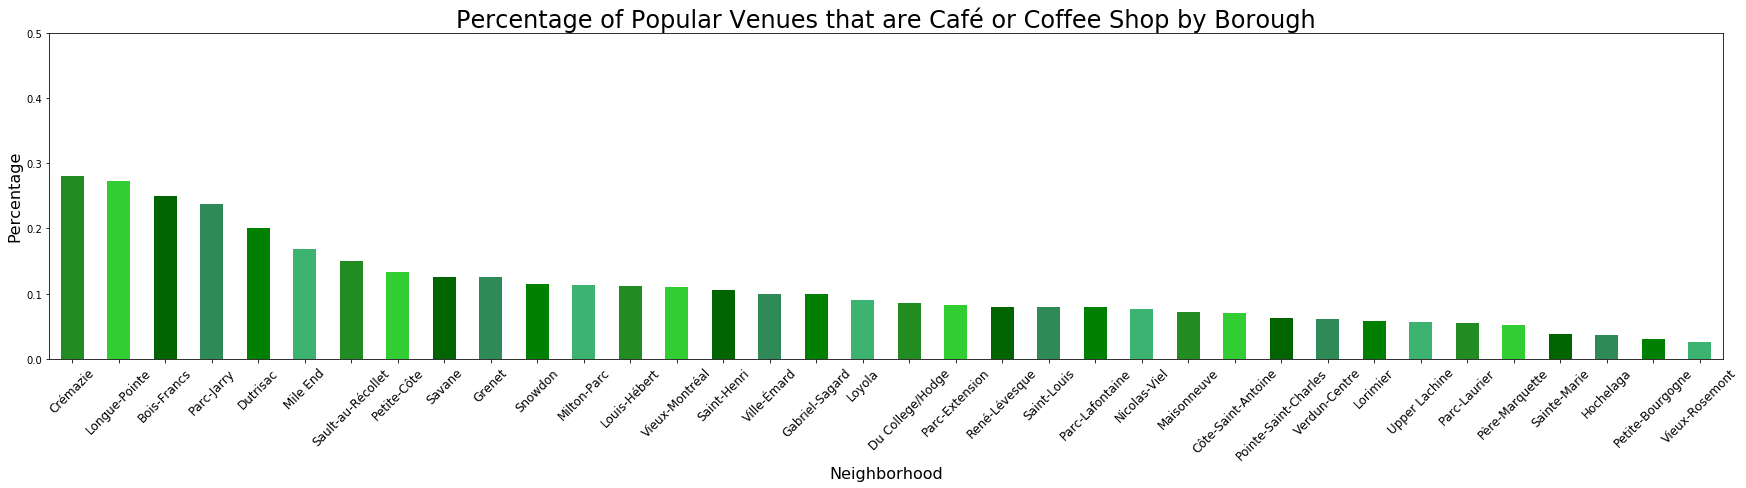

In [40]:
MTL_rb.plot.bar(x='Neighborhood',y ='Frequency', rot = 45, figsize = (30, 6), legend = None , 
                color = ['forestgreen','limegreen','darkgreen','seagreen','green','mediumseagreen'])
plt.ylabel('Percentage', fontsize=16)
plt.xticks(fontsize=12)
plt.xlabel('Neighborhood', fontsize=16)
plt.ylim(0,0.5)
plt.title('Percentage of Popular Venues that are Café or Coffee Shop by Borough', fontsize = 24)
plt.show()

In [41]:
MTL_merged['Latitude'] = MTL_merged['Latitude'].astype(float)
MTL_merged['Longitude'] = MTL_merged['Longitude'].astype(float)
MTL_merged['Cluster Labels'] = MTL_merged['Cluster Labels'].fillna(0).astype(np.int64)

### Map Clustered Neighborhoods¶

Let's pull the coordinates for Montreal and build a map.

In [46]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(.4, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
for lat, lon, poi, cluster, cafe in zip(MTL_merged['Latitude'], MTL_merged['Longitude'], 
                                        MTL_merged['Neighborhood'], MTL_merged['Cluster Labels'], 
                                        MTL_merged['Café & Coffee Shop']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=50*cafe,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(montreal_map)#map_clusters)
       
#map_clusters
montreal_map

### Clusters Analysis

#### Cluster 1

In [43]:
MTL_merged.loc[MTL_merged['Cluster Labels'] == 0,
                     MTL_merged.columns[[0] + [1] +
                                                     list(range(6, MTL_merged.shape[1]))]]

Neighborhood                                   Borough  \
0   Rivière-des-Prairies  Rivière-des-Prairies–Pointe-aux-Trembles   
17         Saint-Édouard                 Rosemont–La Petite-Patrie   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0                0              Bus Stop         Women's Store   
17               0                   NaN                   NaN   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0             Donut Shop           Flower Shop     Fish & Chips Shop   
17                   NaN                   NaN                   NaN   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0    Filipino Restaurant  Fast Food Restaurant        Farmers Market   
17                   NaN                   NaN                   NaN   

   9th Most Common Venue 10th Most Common Venue  Café & Coffee Shop  
0     Falafel Restaurant            Event Space                 0.0  
17                   NaN                    NaN                 NaN

#### Cluster 2

In [44]:
MTL_merged.loc[MTL_merged['Cluster Labels'] == 1,
                     MTL_merged.columns[[0] + [1] +
                                                     list(range(6, MTL_merged.shape[1]))]]

Neighborhood                                   Borough  \
1    Pointe-aux-Trembles  Rivière-des-Prairies–Pointe-aux-Trembles   
2     Marc-Aurèle-Fortin  Rivière-des-Prairies–Pointe-aux-Trembles   
3             Beaurivage             Mercier–Hochelaga-Maisonneuve   
4         Tétreaultville             Mercier–Hochelaga-Maisonneuve   
5                 Dupéré             Mercier–Hochelaga-Maisonneuve   
6               Guybourg             Mercier–Hochelaga-Maisonneuve   
7          Longue-Pointe             Mercier–Hochelaga-Maisonneuve   
9            Maisonneuve             Mercier–Hochelaga-Maisonneuve   
10             Hochelaga             Mercier–Hochelaga-Maisonneuve   
11           Préfontaine             Mercier–Hochelaga-Maisonneuve   
12        Marie-Victorin                 Rosemont–La Petite-Patrie   
13           Petite-Côte                 Rosemont–La Petite-Patrie   
14        Vieux-Rosemont                 Rosemont–La Petite-Patrie   
15   Étienne Desmarteaux                 Rosemont–La Petite-Patrie   
16          Louis-Hébert                 Rosemont–La Petite-Patrie   
18        Père-Marquette                 Rosemont–La Petite-Patrie   
19           René-Goupil      Villeray–Saint-Michel–Parc-Extension   
20          Sainte-Lucie      Villeray–Saint-Michel–Parc-Extension   
21     François-Perrault      Villeray–Saint-Michel–Parc-Extension   
22        Gabriel-Sagard      Villeray–Saint-Michel–Parc-Extension   
23        Parc-Extension      Villeray–Saint-Michel–Parc-Extension   
24            Parc-Jarry      Villeray–Saint-Michel–Parc-Extension   
25              Crémazie      Villeray–Saint-Michel–Parc-Extension   
26     Sault-au-Récollet                     Ahuntsic-Cartierville   
27         Saint-Sulpice                     Ahuntsic-Cartierville   
28          Nicolas-Viel                     Ahuntsic-Cartierville   
29         La Visitation                     Ahuntsic-Cartierville   
30      Nouveau-Bordeaux                     Ahuntsic-Cartierville   
32                Savane       Côte-des-Neiges–Notre-Dame-de-Grâce   
33               Snowdon       Côte-des-Neiges–Notre-Dame-de-Grâce   
34    Côte-Saint-Antoine       Côte-des-Neiges–Notre-Dame-de-Grâce   
35     Édouard-Montpetit       Côte-des-Neiges–Notre-Dame-de-Grâce   
36             Parc-Kent       Côte-des-Neiges–Notre-Dame-de-Grâce   
37                Loyola       Côte-des-Neiges–Notre-Dame-de-Grâce   
38         Upper Lachine       Côte-des-Neiges–Notre-Dame-de-Grâce   
39           Ville-Émard                              Le Sud-Ouest   
40           Saint-Henri                              Le Sud-Ouest   
42  Pointe-Saint-Charles                              Le Sud-Ouest   
43      Petite-Bourgogne                              Le Sud-Ouest   
44              Montagne                               Ville-Marie   
45         René-Lévesque                               Ville-Marie   
46          Sainte-Marie                               Ville-Marie   
47        Vieux-Montréal                               Ville-Marie   
48              Lorimier                     Le Plateau-Mont-Royal   
49           Saint-Louis                     Le Plateau-Mont-Royal   
50       Parc-Lafontaine                     Le Plateau-Mont-Royal   
51          Parc-Laurier                     Le Plateau-Mont-Royal   
52              Mile End                     Le Plateau-Mont-Royal   
53           Milton-Parc                     Le Plateau-Mont-Royal   
54  Chameran/Montpellier                             Saint-Laurent   
55                Grenet                             Saint-Laurent   
56              Dutrisac                             Saint-Laurent   
57           Bois-Francs                             Saint-Laurent   
58      Du College/Hodge                             Saint-Laurent   
60         Verdun-Centre                                    Verdun   

    Cluster Labels       1st Most Common Venue      2nd Most Common Venue  \
1             

#### Cluster 3

In [45]:
MTL_merged.loc[MTL_merged['Cluster Labels'] == 2,
                     MTL_merged.columns[[0] + [1] +
                                                     list(range(6, MTL_merged.shape[1]))]]

Neighborhood                        Borough  Cluster Labels  \
8             Louis-Riel  Mercier–Hochelaga-Maisonneuve               2   
31          Cartierville          Ahuntsic-Cartierville               2   
41       Côte-Saint-Paul                   Le Sud-Ouest               2   
59  Desmarchais-Crawford                         Verdun               2   
61        Ile-des-Soeurs                         Verdun               2   

         1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
8                 Skating Rink                  Park         Women's Store   
31  Construction & Landscaping                  Park           Tailor Shop   
41                        Park    Chinese Restaurant        Ice Cream Shop   
59                        Park                  Pool      Botanical Garden   
61                        Park     Convenience Store            Playground   

       4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
8                    Dog Run   Filipino Restaurant  Fast Food Restaurant   
31        Dongbei Restaurant     Fish & Chips Shop   Filipino Restaurant   
41      Ethiopian Restaurant            Donut Shop   Dumpling Restaurant   
59             Women's Store  Ethiopian Restaurant   Dumpling Restaurant   
61  Mediterranean Restaurant    Dongbei Restaurant   Filipino Restaurant   

          7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
8                Farmers Market    Falafel Restaurant           Event Space   
31         Fast Food Restaurant        Farmers Market    Falafel Restaurant   
41  Eastern European Restaurant     Electronics Store    English Restaurant   
59  Eastern European Restaurant     Electronics Store    English Restaurant   
61         Fast Food Restaurant        Farmers Market    Falafel Restaurant   

   10th Most Common Venue  Café & Coffee Shop  
8    Ethiopian Restaurant                 0.0  
31            Event Space                 0.0  
41            Event Space                 0.0  
59     Falafel Restaurant                 0.0  
61            Event Space                 0.0

 ## 4. Results and Discussion¶

We have pulled data on census individual average income for each boroughs in Montreal and used this information to narrow down boroughs options from 33 boroughs to 11 boroughs with 61 neighborhoods. Our analysis has informed us that:

Café & Coffee Shop, Restaurant, Pharmacy, Park, Bakery, Pizza Place, French Restaurant, Grocery Store, Sandwich Place are the most common venues in our 11 preferred boroughs. 

Clustering neighborhoods based on their most popular venues grouped all 11 preferred boroughs with majority of their neighborhoods categorized into cluster 2.  There are eleven neighborhoods in boroughs such Rivière-des-Prairies–Pointe-aux-Trembles, Mercier–Hochelaga-Maisonneuve, Rosemont–La Petite-Patrie, Ahuntsic-Cartierville, Le Sud-Ouest, Saint-Laurent, and verdun are categorized into Cluster 1 and 3 that Café & Coffee Shop is not popular venue in these neighborhoods.Places such in Mercier–Hochelaga-Maisonneuve, Villeray–Saint-Michel–Parc-Extension, Saint-Laurent, Le Plateau-Mont-Royal, Ville-Marie have majority Café & Coffee shops as popular venues, whereas most of the popular vanues in cluster 1 such as Dutrisac/Saint-Laurent, Louis-Riel/Mercier–Hochelaga-Maisonneuve,Saint-Sulpice/Ahuntsic-Cartierville, Côte-Saint-Paul/Le Sud-Ouest, Café & Coffee shop is not popular venue, but locations like Park, Gym, and restaurant are more popular.  	

Based on this analysis, Longue-Pointe/Mercier–Hochelaga-Maisonneuve, Parc-Jarry and Crémazie/ Villeray–Saint-Michel–Parc-Extension, Bois-Francs/Saint-Laurent, and Mile End / Le Plateau-Mont-Royal	are hot places for Café & Coffee Shops and may not suitable to open a new one. Saint-Laurent, Rosemont–La Petite-Patrie seems to offer a good balance between foot traffic, popularity for Café & Coffee Shop, and might be rent prices. Le Plateau-Mont-Royal and Ville-Marie seems to be a hot spot for Café & Coffee Shop, but also comes with the high cost of rent. 

Loyola / Côte-des-Neiges–Notre-Dame-de-Grâce, René-Lévesque/Ville-Marie, Parc-Extension/Villeray–Saint-Michel–Parc-Extension, Saint-Louis/ Le Plateau-Mont-Royal seem to have similar feel on same clustering but is not hotspot and there are the medium busy neighborhood. Places Rosemont–La Petite-Patrie including four neighborhoods Marie-Victorin, Petite-Côte, Vieux-Rosemont, Louis-Hébert, and Père-Marquette have the most population of average individual income might be better place to open a new Café & Coffee Shop which is popular venue but not much in contrast with other places and has more potential customers too.

Ultimately, the optimal Café & Coffee shop spot depends on what type of Coffee Shop you would like to open. An upscale and trendy Coffee Shop might fare better against competition in an expensive and bustling area like Loyola/Côte-des-Neiges–Notre-Dame-de-Grâce, whereas a university may be the spot in an area, which likely receives most of its foot traffic exclusively from its residents.

A major drawback of this analysis is that the clustering was completely based on Foursquare’ s data for popular venues. There are other ways to assess popularity of neighborhoods and the spots inside them, venue popularity is just one of them. It may also be helpful to look exclusively at Café & Coffee in an area, how many there are, and how popular they are on weekdays and weekends.

## 5. Conclusion


We have executed a project using common python libraries to manipulate data sets, Foursquare API, Montreal Open Data portal, StatCan portal to explore the Montreal Agglomeration, census income data and find popular venues of Montreal, and Folium leaflet map to cluster and segment neighborhoods. This project could be further developed with more census data such as rent price, traffic information, and crime data for each boroughs for more accurate investigation and have better decision.

This was just one use-case. These analytical tools open a world of possibilities for strategic decision making across the various realms of business. 